In [2]:
# libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgbm
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# configuration for plots
plt.rcParams.update({'font.size': 15})

In [3]:
train_df = pd.read_csv('../data/train.csv') # importing train
test_df = pd.read_csv('../data/test.csv') # importing test

In [4]:
train_df.info() # checking datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Checking for duplicated values

In [5]:
train_df.duplicated().sum()

np.int64(0)

# Checking missing values

In [6]:
train_df.isna().sum() / len(train_df)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

We have missing values in the col: **Age, Cabin, Embarked** (I will delete **Cabin** in next step since there is 77% of missing data)
LightGBM can handle missing values automatically without requiring manual imputation for num features treats missing values as a special category during the split finding process basicly it is just lerning direction of missing values during training and for categorical missing values are handled as a separate category, but this eventually impact the score on validation I am not going to build pipeline to impute values here (maybe when packaging this notebook), will just impute values manually after small check of discribution and frequency of catogories.

# Cheking how to impute Age and Embarked

In [ ]:
train_df['Age'].skew()

np.float64(0.38910778230082704)

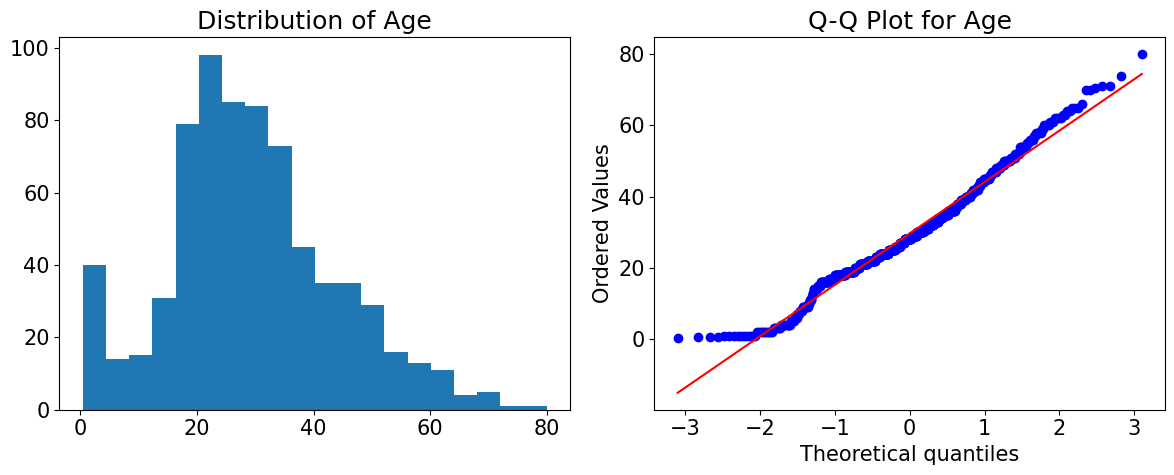

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(train_df['Age'], bins=20)
axs[0].set_title('Distribution of Age')

stats.probplot(train_df['Age'].dropna(), dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot for Age')

plt.tight_layout()
plt.show()

Overall the Age is close to normal but with some right skewness, consequently the median would be more robust to the slight right skew and outliers

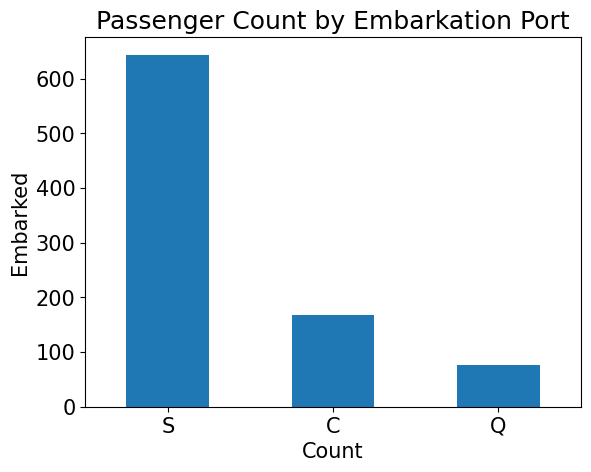

In [9]:
train_df['Embarked'].value_counts().plot(kind='bar') # exploration of Embarked col to determine strategy for imputation
plt.title("Passenger Count by Embarkation Port")
plt.xlabel("Count")
plt.xticks(rotation = 0)
plt.ylabel("Embarked")
plt.show()

In [10]:
# consequently filling Age with median and Embarked with most frequent
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# Checking target

Before builing classification model just want to make sure or dataset is balanced or not, to use proper strategy and evaluation metrics in the future

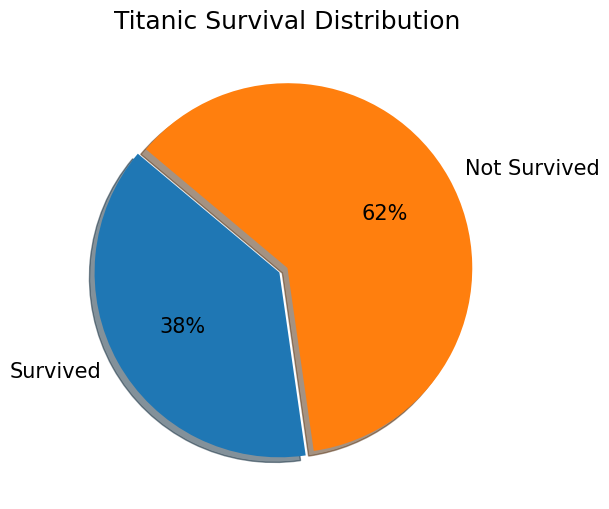

In [13]:
count = [train_df['Survived'].sum(), len(train_df) - train_df['Survived'].sum()]
countfig, ax = plt.subplots(figsize=(6,6))
ax.pie(count, labels = ['Survived', 'Not Survived'], autopct = '%1.0f%%', shadow = True, explode = [0.05, 0], startangle = 140)
ax.set_title("Titanic Survival Distribution")
plt.show()

There is no need to implement oversampling 

# Preprosessing

It typically involves:

- Removing irrelevant or noisy features that don not contribute to prediction (**`Name`, `Ticket`, `Cabin`, `PassengerId`, `Parch`** due to the fact that some of them are not informative and week when creating model) ***Note: This conclusion was made after performing exploratory data analysis and testing the model with all available features.***


- Splitting data into training and testing sets to evaluate model performance

- Encoding categorical variables into numerical format for algorithms that require it (will use OrdinalEncoder to convert categorical variables **`Sex`, `Embarked`** into numeric format. LightGBM can natively handle categorical features, but they must be represented as integers according to [documentation](https://lightgbm.readthedocs.io/en/v3.3.2/Advanced-Topics.html#categorical-feature-support).

- Usually normalize features but in this case not required for tree-based models like LightGBM

- For LightGBM model good practice to specifying categorical features to improve performance and interpretability


In [14]:
X = train_df.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId', 'Parch'], axis=1)
y = train_df['Survived']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
categorical_cols = ["Sex", "Embarked"]
encoder = OrdinalEncoder()
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    float64
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Fare      712 non-null    float64
 5   Embarked  712 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 38.9 KB


In [18]:
train_data = lgbm.Dataset(X_train, label = y_train, categorical_feature = ['Pclass', 'Sex', 'Embarked'])
test_data = lgbm.Dataset(X_test, label = y_test, reference=train_data)

In [19]:
model = lgbm.LGBMClassifier(objective='binary',
                            num_leaves=20,
                            learning_rate=0.01,
                            n_estimators=400)

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],  # to plot learning curve on next step
          eval_names = ["train", "test"], # to plot learning curve on next step
          eval_metric = "binary_logloss",
          callbacks = [lgbm.early_stopping(stopping_rounds=10)])


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[358]	train's binary_logloss: 0.299254	test's binary_logloss: 0.401454


LGBMClassifier(learning_rate=0.01, n_estimators=400, num_leaves=20,
               objective='binary')

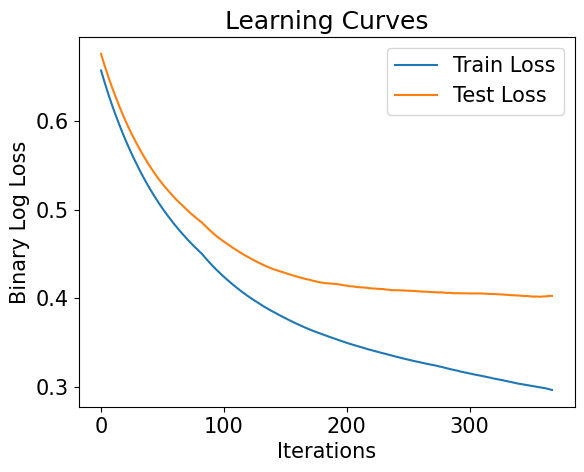

In [20]:
train_loss = model.evals_result_["train"]["binary_logloss"]
test_loss = model.evals_result_["test"]["binary_logloss"]

plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Iterations")
plt.ylabel("Binary Log Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()

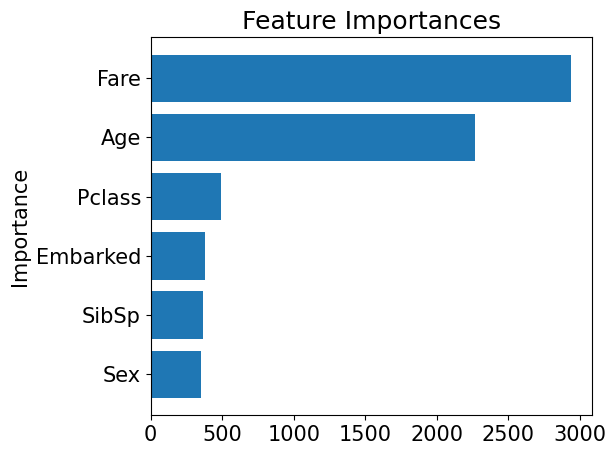

In [21]:
importances = pd.DataFrame({'features': model.feature_name_,
                            'importance': model.feature_importances_}).sort_values('importance')

plt.barh(importances['features'], importances['importance'])
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [24]:
preds = np.round(model.predict(X_test))

print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
print(f"Precision: {precision_score(y_test, preds):.3f}")
print(f"Recall: {recall_score(y_test, preds):.3f}")
print(f"F1: {f1_score(y_test, preds):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, preds):.3f}")

Accuracy: 0.821
Precision: 0.800
Recall: 0.757
F1: 0.778
MCC: 0.629


# Saving model

In [26]:
joblib.dump(model, '../models/model.joblib') # to explort model

['../models/model.joblib']